1. Loading and previewing GDNat Data

In [2]:
# import necessary libraries

import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import glob
import cftime
from datetime import datetime



In [3]:
# set file paths

data_dir_cullen = os.path.join(
    "/global",
    "scratch",
    "users",
    "cmolitor",
)

data_dir_gdnat = os.path.join(data_dir_cullen, "global_suicide")

gdnat_1 = os.path.join(
    data_dir_gdnat,
    "climate_data",
    "gdnat_ACCESS-CM2_tas_1979-1999_v2025-02-11.zarr",
)

gdnat_2 = os.path.join(
    data_dir_gdnat,
    "climate_data",
    "gdnat_ACCESS-CM2_tas_2000-2020_v2025-02-11.zarr",
)

data_dir_era5 = "/global/scratch/users/yougsanghvi"


In [4]:
# load data
gdnat_data_1 = xr.open_zarr(gdnat_1)
gdnat_data_2 = xr.open_zarr(gdnat_2)

1A. View and Verify Data

In [32]:
# view the data
# gdnat_data

# gdnat_data_1.values
gdnat_data_2.values

<bound method Mapping.values of <xarray.Dataset> Size: 32GB
Dimensions:  (lat: 720, lon: 1440, model: 1, time: 7665)
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * model    (model) object 8B 'ACCESS-CM2'
  * time     (time) object 61kB 2000-01-01 00:00:00 ... 2020-12-31 00:00:00
Data variables:
    tas      (model, time, lat, lon) float32 32GB dask.array<chunksize=(1, 365, 100, 100), meta=np.ndarray>
Attributes:
    Created by:     Robert Fofrich <robertfofrich@ucla.edu>
    Creation date:  Compiled ZARR store created and saved 2025-02-11 01:39:52...
    Description:    GDNat: a global, daily, high-resolution natural-forcing o...
    Method:         Use Quantile Delta Mapping to apply quantile-by-quantile ...
    Repo:           https://github.com/ClimateImpactLab/gdnat
    Source files:   gs://impactlab-data/climate/attribution/outputs/hist-nat-...>

In [ ]:
# List files in the directory to verify 


dir_toverify = data_dir_era5

"""
try:
    files = os.listdir(dir_toverify)
    print(f"Files in {dir_toverify}:")
    for file in files:
        print(file)
except FileNotFoundError:
    print(f"Directory not found: {dir_toverify}")
except PermissionError:
    print(f"Permission denied to access: {dir_toverify}")
"""

files = sorted(
    [f for f in os.listdir(data_dir_era5) if f.endswith(".nc") and f.startswith("era5_daily_mean")]
)

print("Found files:")
for f in files:
    print(f)

In [ ]:
# preview the data - see all timestamps between a range to confirm frequency

"""
# Define the time range
start_date = "1979-09-01"
end_date = "1979-09-03"

# Extract and print timestamps within that range
timestamps_in_range = gdnat_data.sel(time=slice(start_date, end_date)).time.values
print("Timestamps in range:")
for t in timestamps_in_range:
    print(t)

# preview the data for one timeframe 

# Select one timestamp to preview tas values
snapshot = gdnat_data['tas'].sel(time='1979-09-02T00:00:00')

# Convert to table format
df_snapshot = snapshot.squeeze().to_dataframe().reset_index()
print("\nSnapshot of tas values on 1979-09-02:")
print(df_snapshot.head(10))
"""


In [33]:


era5_file = os.path.join(data_dir_era5,"era5_daily_mean_2019.nc")  # update path as needed
ds = xr.open_dataset(era5_file)
print(ds)


<xarray.Dataset> Size: 2GB
Dimensions:    (time: 365, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    t2m        (time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-06T11:24 GRIB to CDM+CF via cfgrib-0.9.1...


/tmp/ipykernel_1931661/2941094826.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(era5_file)


2. Comparitive exploration of GDNat and ERA5 Data

2A. (Doesn't work) Computing LR averages for each location-day pair across years

Can possibly replace with a function to do so for a specific grid cell(s) and save seperately if that helps 

In [ ]:
# calculating LR averages for each day-location pair

# Combine the two datasets
gdnat_combined = xr.concat([gdnat_data_1["tas"], gdnat_data_2["tas"]], dim="time")

# Convert time to pandas datetime index if needed
gdnat_combined["time"] = xr.cftime_range(
    start=str(gdnat_combined["time.year"][0].item()),
    periods=gdnat_combined.sizes["time"],
    freq="D",
)

# Add month-day coordinate
gdnat_combined.coords["month_day"] = (
    ("time",),
    [f"{t.month:02d}-{t.day:02d}" for t in gdnat_combined["time"].values],
)

# Group by month-day and average across years
gdnat_lr_avg = gdnat_combined.groupby("month_day").mean(dim="time")

/tmp/ipykernel_3388723/398171773.py:7: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  gdnat_combined['time'] = xr.cftime_range(start=str(gdnat_combined['time.year'][0].item()),


In [35]:
gdnat_lr_avg

<xarray.DataArray 'tas' (model: 1, month_day: 366, lat: 720, lon: 1440)> Size: 2GB
dask.array<transpose, shape=(1, 366, 720, 1440), dtype=float32, chunksize=(1, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
  * lon        (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * model      (model) object 8B 'ACCESS-CM2'
  * month_day  (month_day) object 3kB '01-01' '01-02' ... '12-30' '12-31'
Attributes:
    Description:      Surface air temperature at the reference height (typica...
    Variable names:   originally t2m in ERA5, tas in CMIP6 earth system model...
    bias_adjustment:  QuantileDeltaMapping(group=Grouper(name='time.dayofyear...
    history:          [2023-06-01 20:44:19] : Bias-adjusted with QuantileDelt...
    units:            K

In [ ]:
# Define data directory and file pattern
era5_path_pattern = os.path.join(data_dir_era5, "era5_daily_mean_*.nc")

# Preprocessing to remove leap day (Feb 29)
"""
def preprocess(ds):
    return ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))
"""

# Load all files efficiently
print("loading dataset...")
era5_all = xr.open_mfdataset(
    era5_path_pattern,
    combine="by_coords",
    # preprocess=preprocess,
    decode_timedelta=True,
)

# Create month_day datetime objects with dummy year 1680 indicating it is LR average
print("generating month-day datetime objects...")
month_day_dt = [t.replace(year=1680) for t in pd.to_datetime(era5_all.time.values)]
era5_all = era5_all.assign_coords(month_day=("time", month_day_dt))

# Compute long-run average (in Celsius)
print("computing means...")
era5_lr_avg = era5_all["t2m"].groupby("month_day").mean(dim="time") - 273.15

loading dataset...
generating month-day datetime objects...
computing means...


In [30]:
era5_lr_avg

<xarray.DataArray 't2m' (month_day: 366, latitude: 721, longitude: 1440)> Size: 2GB
dask.array<sub, shape=(366, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    number     int64 8B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * month_day  (month_day) datetime64[ns] 3kB 1680-01-01 ... 1680-12-31

In [ ]:
# Convert datetime-like month_day to string with dummy year
print("converting datetime to string with dummy year...")
md_strings = [
    "2000-" + pd.Timestamp(md).strftime("%m-%d")
    for md in era5_lr_avg["month_day"].values
]
md_index = pd.to_datetime(md_strings, format="%Y-%m-%d")

print("narrowing down location...")
# Narrow to New Delhi
era5_lr_avg_point = era5_lr_avg.sel(latitude=28.6, longitude=77.2, method="nearest")

# Create DataArray with time-like index
print("creating a data array...")
era5_lr_series = xr.DataArray(
    era5_lr_avg_point.values, coords={"time": md_index}, dims="time"
)

# Plotting
print("plotting...")
plt.figure(figsize=(12, 5))
plt.plot(
    era5_lr_series["time"],
    era5_lr_series,
    label="ERA5 Long-Run Avg (1979–2020)",
    color="orange",
)
plt.title("ERA5 Long-Run Daily Mean 2m Temperature (°C) – New Delhi")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


converting datetime to string with dummy year...
narrowing down location...
creating a data array...


MemoryError: Unable to allocate 1.42 GiB for an array with shape (366, 721, 1440) and data type float32

2B. Computing differences in GDNat and ERA5 for specified location and range 

Can and should be extended to doing this for all, but this is simpler and helps with memory issues

In [7]:


def compute_temperature_difference(location, time_range, era5_data, gdnat_data):
    """
    Computes the difference in surface temperature between ERA5 and GDNat datasets
    for a given location and time range.

    Parameters:
        location (tuple): Latitude and Longitude of the point (lat, lon)
        time_range (tuple): Start and End dates (start_date, end_date) in 'YYYY-MM-DD' format
        era5_data (xarray.Dataset): ERA5 dataset with 't2m' variable
        gdnat_data (xarray.Dataset): GDNat dataset with 'tas' variable

    Returns:
        xarray.DataArray: Difference in temperatures (ERA5 - GDNat) in Celsius
    """
    lat, lon = location
    start_date, end_date = time_range

    # Select nearest grid point in both datasets and time slice
    era5_point = (
        era5_data["t2m"]
        .sel(latitude=lat, longitude=lon, method="nearest")
        .sel(time=slice(start_date, end_date))
        - 273.15
    )

    gdnat_point = (
        gdnat_data["tas"]
        .sel(lat=lat, lon=lon, method="nearest")
        .sel(time=slice(start_date, end_date))
        - 273.15
    )

    # Convert both time axes to datetime64[ns] for consistency
    era5_time = np.array(era5_point['time'].values, dtype='datetime64[ns]')
    gdnat_time = np.array(gdnat_point['time'].values, dtype='datetime64[ns]')

    era5_point = era5_point.assign_coords(time=era5_time)
    gdnat_point = gdnat_point.assign_coords(time=gdnat_time)

    # Align both datasets along time (robust to mismatches)
    era5_aligned, gdnat_aligned = xr.align(era5_point, gdnat_point, join="inner")

    # Compute the difference
    difference = era5_aligned - gdnat_aligned

    return difference


2C. Function to find the average temperature for specific day-range and location across previous years

In [96]:
def average_temperature_over_range(location, start_date, end_date):
    """
    Efficiently calculate the average temperature over a specified date range for a given location,
    averaging across all previous years in the datasets.
    
    Uses lazy loading for ERA5 files to improve performance.
    """
    lat, lon = location
    data_dir_era5 = "/global/scratch/users/yougsanghvi"

    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")

    requested_dates = pd.date_range(start=start_dt, end=end_dt)
    month_days = [(d.month, d.day) for d in requested_dates]

    # Preselect grid points for GDNat (nearest neighbor)
    lat_gdnat = float(gdnat_data_1['lat'].sel(lat=lat, method="nearest").values)
    lon_gdnat = float(gdnat_data_1['lon'].sel(lon=lon, method="nearest").values)

    # Determine lat/lon grid points for ERA5
    sample_era5_file = os.path.join(data_dir_era5, "era5_daily_mean_2019.nc")
    era5_sample = xr.open_dataset(sample_era5_file)
    lat_era5 = float(era5_sample['latitude'].sel(latitude=lat, method="nearest").values)
    lon_era5 = float(era5_sample['longitude'].sel(longitude=lon, method="nearest").values)
    era5_sample.close()

    # Load all ERA5 datasets lazily using open_mfdataset for efficiency
    era5_files_pattern = os.path.join(data_dir_era5, "era5_daily_mean_*.nc")
    era5_all_years = xr.open_mfdataset(era5_files_pattern, combine='by_coords')

    # Preselect grid point from ERA5 once
    era5_point = era5_all_years['t2m'].sel(latitude=lat_era5, longitude=lon_era5, method="nearest")

    output_rows = []

    for month, day in month_days:
        # GDNat: Gather all temperatures for this (month, day) over all years
        temps_gdnat_1 = gdnat_data_1['tas'].sel(lat=lat_gdnat, lon=lon_gdnat, method="nearest")
        temps_gdnat_2 = gdnat_data_2['tas'].sel(lat=lat_gdnat, lon=lon_gdnat, method="nearest")

        matching_gdnat_1 = temps_gdnat_1.sel(time=temps_gdnat_1['time'].dt.month == month)
        matching_gdnat_1 = matching_gdnat_1.sel(time=matching_gdnat_1['time'].dt.day == day)

        matching_gdnat_2 = temps_gdnat_2.sel(time=temps_gdnat_2['time'].dt.month == month)
        matching_gdnat_2 = matching_gdnat_2.sel(time=matching_gdnat_2['time'].dt.day == day)

        combined_gdnat = xr.concat([matching_gdnat_1, matching_gdnat_2], dim='time')
        avg_gdnat_temp = (combined_gdnat - 273.15).mean().compute().item() if combined_gdnat.time.size > 0 else np.nan

        # ERA5: Gather all temperatures for this (month, day) over all years
        matching_era5 = era5_point.sel(time=era5_point['time'].dt.month == month)
        matching_era5 = matching_era5.sel(time=matching_era5['time'].dt.day == day)

        avg_era5_temp = (matching_era5 - 273.15).mean().compute().item() if matching_era5.time.size > 0 else np.nan

        date_str = f"{start_dt.year}-{month:02d}-{day:02d}"
        output_rows.append({
            "date": date_str,
            "latitude_gdnat": lat_gdnat,
            "longitude_gdnat": lon_gdnat,
            "latitude_era5": lat_era5,
            "longitude_era5": lon_era5,
            "avg_temperature_gdnat": avg_gdnat_temp,
            "avg_temperature_era5": avg_era5_temp,
        })

    df = pd.DataFrame(output_rows)
    df["temp_diff_era5_minus_gdnat_C"] = df["avg_temperature_era5"] - df["avg_temperature_gdnat"]
    
    return df


In [97]:
# Example test call
location = (28.61, 77.21)  # New Delhi lat, lon
start_date = "2019-01-01"
end_date = "2019-01-05"

df_avg_temps = average_temperature_over_range(location, start_date, end_date)

print(df_avg_temps)


/tmp/ipykernel_1931661/124343318.py:23: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_sample = xr.open_dataset(sample_era5_file)
/tmp/ipykernel_1931661/124343318.py:30: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_all_years = xr.open_mfdataset(era5_files_pattern, combine='by_coords')
/tmp/ipykernel_1931661/124343318.py:30: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_all_years = xr.open_mfdataset(era5_files_pattern, combine='by_coords')
/tmp/ipykernel_1931661/124343318.py:30: FutureWarning: In a future version of xa

KeyboardInterrupt: 

In [80]:
print(df_avg_temps.dtypes)


date                      object
latitude_gdnat           float64
longitude_gdnat          float64
latitude_era5            float64
longitude_era5           float64
avg_temperature_gdnat    float64
avg_temperature_era5     float64
dtype: object


3. Plotting 

In [ ]:
# Clean data to plot a map with an estimate for anthropogenic global warming

# Set your time range for comparison
start_date = "2000-01-01"
end_date = "2011-12-31"

# Load ERA5 daily data (merge across years if needed)

era5_files = [
    f"{data_dir_era5}/era5_daily_mean_{year}.nc" for year in range(2000, 2012)
]

print("loading ERA5 files")
era5_ds = xr.open_mfdataset(
    era5_files, combine="by_coords", decode_timedelta=True, chunks={"time": 365}
)

print("finished ERA5 loading files")

# Select time range
print("slicing both files")
era5_sel = era5_ds.sel(time=slice(start_date, end_date))
gdnat_sel = gdnat_data_2.sel(time=slice(start_date, end_date))
print("finished slicing files")

# Ensure temperature units are comparable (ERA5 is in Kelvin, GDNat usually too)
print("converting to celsius")
era5_temp = era5_sel["t2m"] - 273.15  # Convert to °C
gdnat_temp = gdnat_sel["tas"].squeeze() - 273.15  # Remove 'model' dim
print("finished converting to celsius")

# Time-average both
print("computing means")
era5_mean = era5_temp.mean(dim="time").compute()
gdnat_mean = gdnat_temp.mean(dim="time").compute()
print("finished computing means")

# ensure alignment for merging
gdnat_mean = gdnat_mean.rename({"lat": "latitude", "lon": "longitude"})

print("ERA5 shape:", era5_mean.shape)
print("GDNat shape:", gdnat_mean.shape)
print("ERA5 dims:", era5_mean.dims)
print("GDNat dims:", gdnat_mean.dims)

# Delta (Panel F)
delta = era5_mean - gdnat_mean

loading ERA5 files
finished ERA5 loading files
slicing both files
finished slicing files
converting to celsius
finished converting to celsius
computing means
finished computing means
ERA5 shape: (721, 1440)
GDNat shape: (720, 1440)
ERA5 dims: ('latitude', 'longitude')
GDNat dims: ('latitude', 'longitude')


In [22]:
# previewing the resulting mean files

# era5_mean.values
# era5_mean

gdnat_mean


<xarray.DataArray 'tas' (latitude: 720, longitude: 1440)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(720, 1440), dtype=float32)
Coordinates:
  * latitude   (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.25 89.5 89.75
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    model      <U10 40B 'ACCESS-CM2'

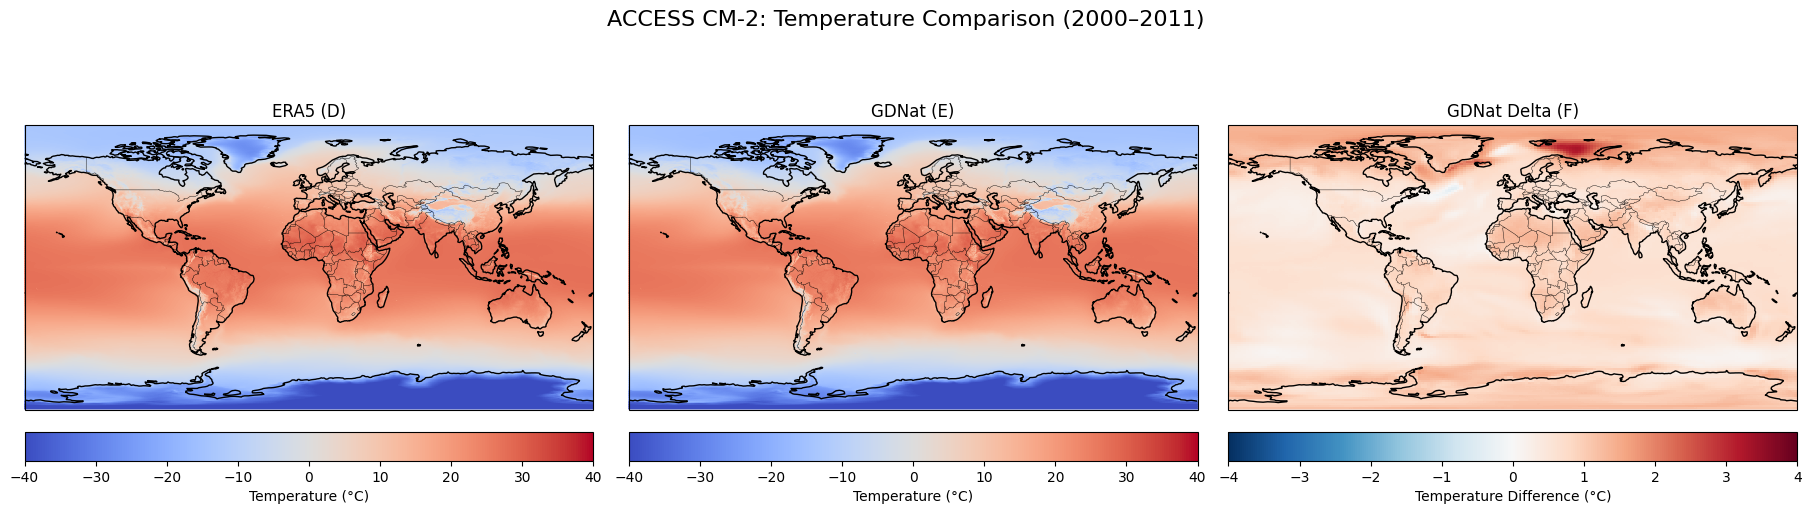

In [ ]:
# Plotting a map with an estimate for anthropogenic global warming
fig, axs = plt.subplots(
    1,
    3,
    figsize=(18, 5),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,
)

# Panel D: ERA5
im1 = axs[0].pcolormesh(
    era5_mean["longitude"],
    era5_mean["latitude"],
    era5_mean,
    cmap="coolwarm",
    vmin=-40,
    vmax=40,
    transform=ccrs.PlateCarree(),
)
axs[0].set_title("ERA5 (D)")
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linewidth=0.3)
plt.colorbar(im1, ax=axs[0], orientation="horizontal", label="Temperature (°C)")

# Panel E: GDNat
im2 = axs[1].pcolormesh(
    gdnat_mean["longitude"],
    gdnat_mean["latitude"],
    gdnat_mean,
    cmap="coolwarm",
    vmin=-40,
    vmax=40,
    transform=ccrs.PlateCarree(),
)
axs[1].set_title("GDNat (E)")
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linewidth=0.3)
plt.colorbar(im2, ax=axs[1], orientation="horizontal", label="Temperature (°C)")

# Panel F: Delta
im3 = axs[2].pcolormesh(
    delta["longitude"],
    delta["latitude"],
    delta,
    cmap="RdBu_r",
    vmin=-4,
    vmax=4,
    transform=ccrs.PlateCarree(),
)
axs[2].set_title("GDNat Delta (F)")
axs[2].coastlines()
axs[2].add_feature(cfeature.BORDERS, linewidth=0.3)
plt.colorbar(
    im3, ax=axs[2], orientation="horizontal", label="Temperature Difference (°C)"
)

plt.suptitle("ACCESS CM-2: Temperature Comparison (2000–2011)", fontsize=16)
plt.show()


In [5]:
# check if file exists before analyzing heatwave data

# Define the full path to the file you want to check
file_path = os.path.join(data_dir_era5, "era5_daily_mean_2019.nc")

# Check if it exists
if os.path.exists(file_path):
    print("File exists ✅")
else:
    print("File not found ❌")

File not found ❌


3B. Plotting Time Series

In [5]:
def plot_heatwave_comparison(location, heatwave_period, plot_range, title, heatwave):
    """
    Plot observed (ERA5) and counterfactual (GDNat) temperatures with a secondary y-axis for the anthropogenic component.
    
    Parameters:
        location (tuple): (latitude, longitude)
        heatwave_period (tuple): (start_date, end_date) of the heatwave for highlighting
        plot_range (tuple): (start_date, end_date) for the x-axis time range
        title (str): Title of the plot
        heatwave (bool): Whether to highlight the heatwave period
    """

    print("Plotting your GDNat and ERA5 plot...")

    lat, lon = location
    start_date, end_date = plot_range

    # Determine which GDNat file to use based on the year
    year = pd.to_datetime(start_date).year
    if year <= 1999:
        gdnat_data = gdnat_data_1
    else:
        gdnat_data = gdnat_data_2

    # Load ERA5 data for the relevant year
    era5_file = os.path.join(data_dir_era5, f"era5_daily_mean_{year}.nc")
    era5_data = xr.open_dataset(era5_file)

    # Select nearest grid points and slice by time
    era5_point = (
        era5_data["t2m"]
        .sel(latitude=lat, longitude=lon, method="nearest")
        .sel(time=slice(start_date, end_date))
        - 273.15
    )
    gdnat_point = (
        gdnat_data["tas"]
        .sel(lat=lat, lon=lon, method="nearest")
        .sel(time=slice(start_date, end_date))
        .squeeze()
        - 273.15
    )

    anthropogenic_component = compute_temperature_difference(location, (start_date, end_date), era5_data, gdnat_data)

    # test the anthropogenic means:

    """
    print("ERA5 sample:", era5_point.values[:5])
    print("GDNat sample:", gdnat_point.values[:5])
    print("Anthropogenic Component sample (ERA5 - GDNat):", anthropogenic_component.values[:5])

    print("Anthropogenic Component Mean (°C):", anthropogenic_component.mean().compute().item())
    print("Anthropogenic Component Std Dev (°C):", anthropogenic_component.std().compute().item())
    print("Anthropogenic Component min/max (°C):", anthropogenic_component.min().compute().item(), anthropogenic_component.max().compute().item())
    """


    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot ERA5 and GDNat on primary y-axis
    ax1.plot(
        era5_point["time"],
        era5_point,
        label=f"ERA5 Actual Temperature ({year})",
        color="red",
    )
    ax1.plot(
        gdnat_point["time"],
        gdnat_point,
        label=f"GDNat Counterfactual ({year})",
        color="blue",
    )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Temperature (°C)", color="black")
    ax1.tick_params(axis='y', labelcolor="black")

    # Highlight heatwave period if requested
    if heatwave:
        heat_start, heat_end = heatwave_period
        ax1.axvspan(
            np.datetime64(heat_start),
            np.datetime64(heat_end),
            color="gray",
            alpha=0.3,
            label="Heatwave Period",
        )

    # Secondary y-axis for anthropogenic component
    ax2 = ax1.twinx()
    ax2.plot(
        anthropogenic_component["time"],
        anthropogenic_component,
        label="Anthropogenic Component (ERA5 - GDNat)",
        color="black",
        linestyle="--",
    )
    ax2.set_ylabel("Anthropogenic Component (°C)", color="black")
    ax2.tick_params(axis='y', labelcolor="black")

    """
    # Get average temperature difference DataFrame for the heatwave period
    df_avg_diff = average_temperature_over_range(location, plot_range[0], plot_range[1])

    # Calculate mean difference over the period
    avg_diff = (df_avg_diff["avg_temperature_era5"] - df_avg_diff["avg_temperature_gdnat"]).mean()

    # Plot horizontal line on secondary y-axis for average difference
    ax2.axhline(
        avg_diff,
        color="red",
        linestyle=":",
        linewidth=2,
        label=f"Avg Diff ERA5-GDNat ({plot_range[0]} to {plot_range[1]})"
    )

    # Update legend for secondary axis to include this new line
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc="upper right")
    """

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

    ax1.set_title(title)
    ax1.grid(True, which="both", linestyle="--", color="gray", alpha=0.7)
    ax1.tick_params(axis='x', labelsize=8)
    ax1.tick_params(axis='y', labelsize=8)
    ax2.tick_params(axis='y', labelsize=8)
    ax2.set_ylim(anthropogenic_component.min().compute().item(), 20)


    plt.tight_layout()
    plt.show()


Plotting your GDNat and ERA5 plot...


/tmp/ipykernel_1931661/1210747063.py:27: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_data = xr.open_dataset(era5_file)


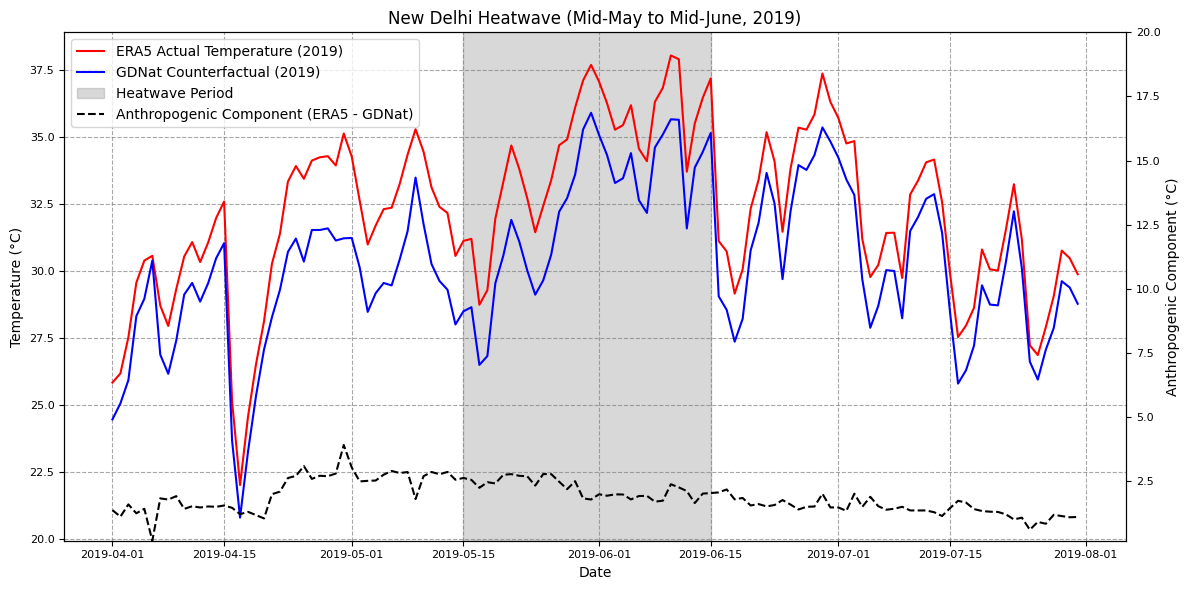

In [99]:
plot_heatwave_comparison(
    location=(28.61, 77.21),
    heatwave_period=("2019-05-15", "2019-06-15"),
    heatwave=True,
    plot_range=("2019-04-01", "2019-07-31"),
    title="New Delhi Heatwave (Mid-May to Mid-June, 2019)",
)


Plotting your GDNat and ERA5 plot...


/tmp/ipykernel_1931661/1210747063.py:27: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_data = xr.open_dataset(era5_file)


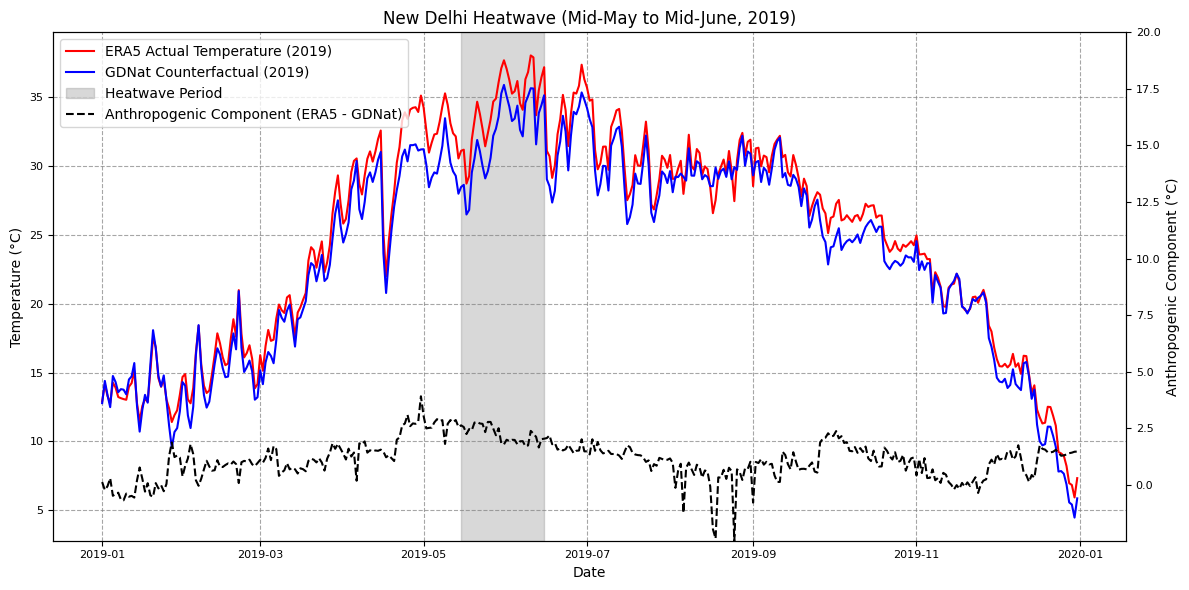

In [100]:
plot_heatwave_comparison(
    location=(28.61, 77.21),
    heatwave_period=("2019-05-15", "2019-06-15"),
    plot_range=("2019-01-01", "2019-12-31"),
    title="New Delhi Heatwave (Mid-May to Mid-June, 2019)",
    heatwave = True,
)

Plotting your GDNat and ERA5 plot...


/tmp/ipykernel_1931661/1210747063.py:27: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_data = xr.open_dataset(era5_file)


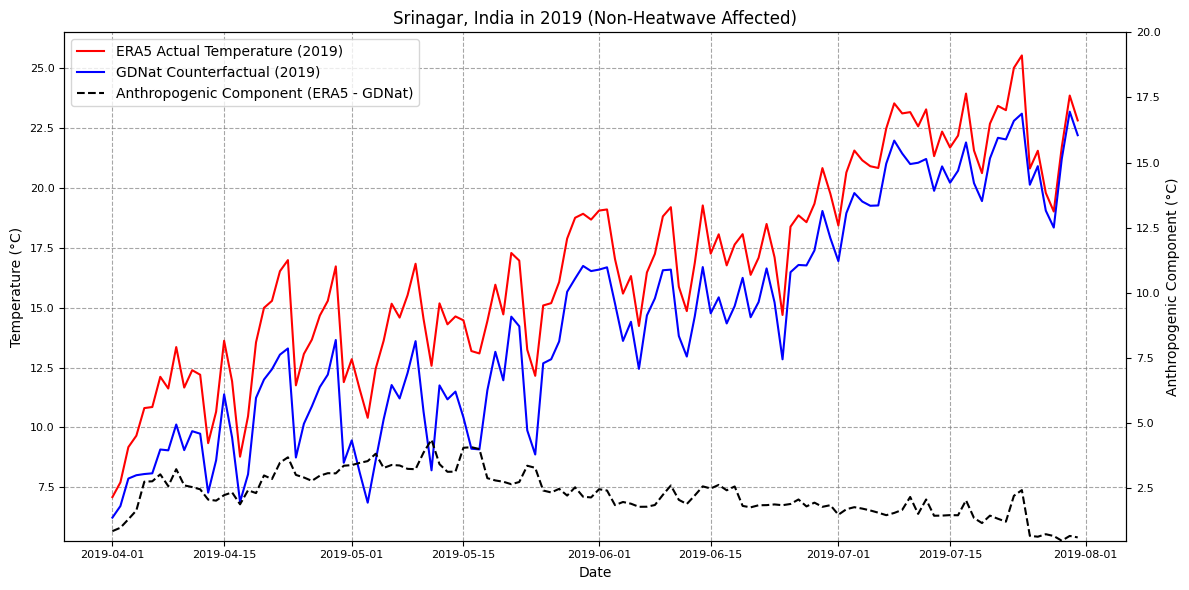

In [102]:
# comparision to colder part of India -- Kashmir is chosen here

plot_heatwave_comparison(
    location=(34.08, 74.79),  # Srinagar, India
    heatwave_period=("2019-05-15", "2019-08-15"),
    plot_range=("2019-04-01", "2019-07-31"),
    title="Srinagar, India in 2019 (Non-Heatwave Affected)",
    heatwave=False,
)


Plotting your GDNat and ERA5 plot...


/tmp/ipykernel_1931661/1210747063.py:27: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_data = xr.open_dataset(era5_file)


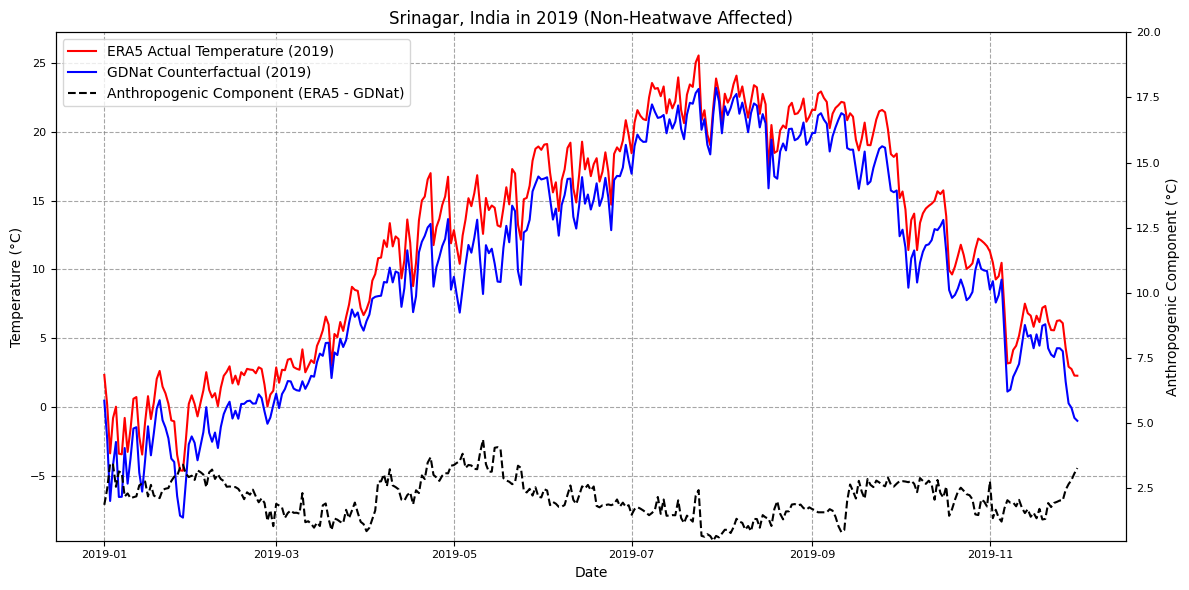

In [105]:
# full year version


plot_heatwave_comparison(
    location=(34.08, 74.79),  # Srinagar, India
    heatwave_period=("2019-01-01", "2019-12-01"),
    plot_range=("2019-01-01", "2019-12-01"),
    title="Srinagar, India in 2019 (Non-Heatwave Affected)",
    heatwave=False,
)

Plotting your GDNat and ERA5 plot...


/tmp/ipykernel_1931661/1210747063.py:27: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_data = xr.open_dataset(era5_file)


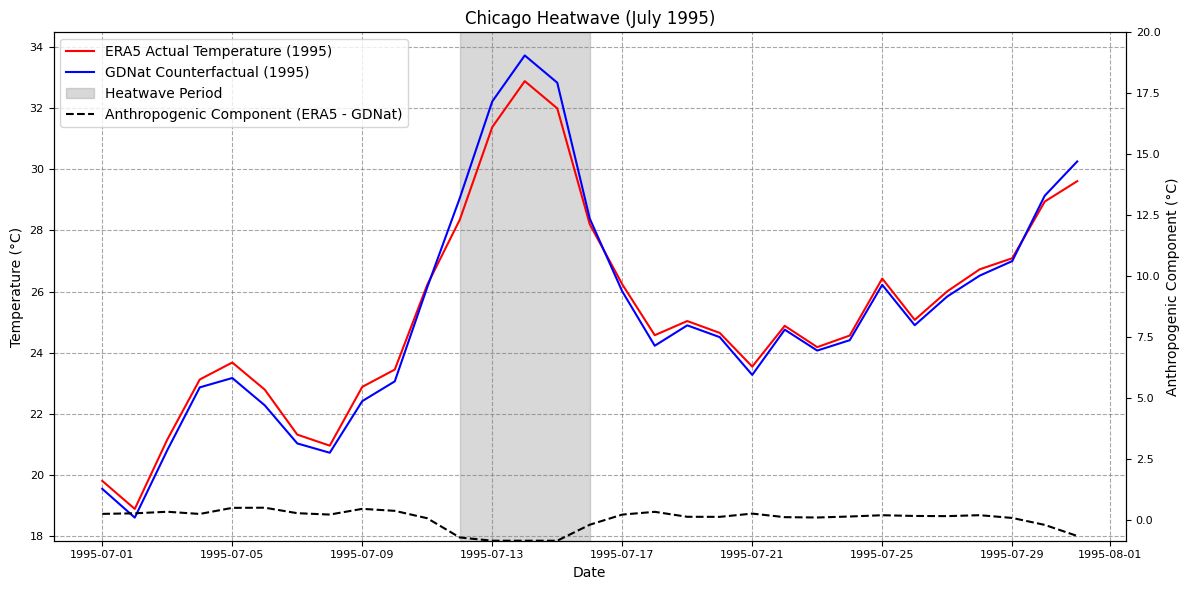

In [107]:
plot_heatwave_comparison(
    location=(41.88, 272.37),  # Chicago lat, ERA5 longitude
    heatwave_period=("1995-07-12", "1995-07-16"),  # Heatwave dates
    plot_range=("1995-07-01", "1995-07-31"),  # Wider plot range for context
    title="Chicago Heatwave (July 1995)",
    heatwave = True
)


Plotting your GDNat and ERA5 plot...


/tmp/ipykernel_1931661/1210747063.py:27: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_data = xr.open_dataset(era5_file)


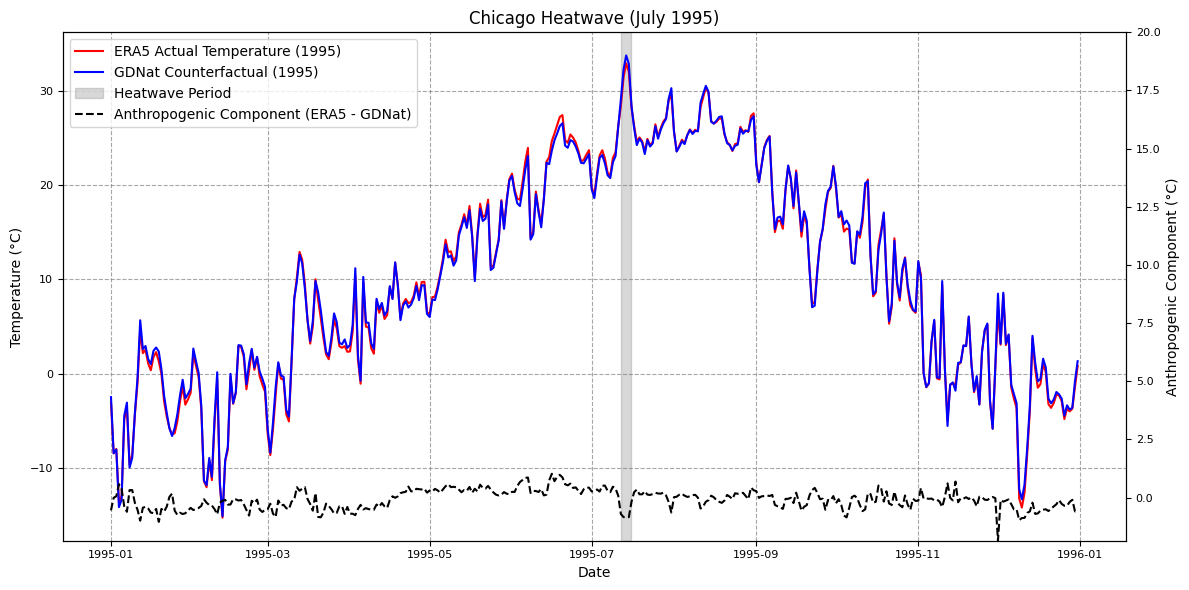

In [108]:
plot_heatwave_comparison(
    location=(41.88, 272.37),  # Chicago lat, ERA5 longitude
    heatwave_period=("1995-07-12", "1995-07-16"),  # Heatwave dates
    plot_range=("1995-01-01", "1995-12-31"), 
    title="Chicago Heatwave (July 1995)",
    heatwave = True
)


Plotting your GDNat and ERA5 plot...


/tmp/ipykernel_1963616/1210747063.py:27: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_data = xr.open_dataset(era5_file)


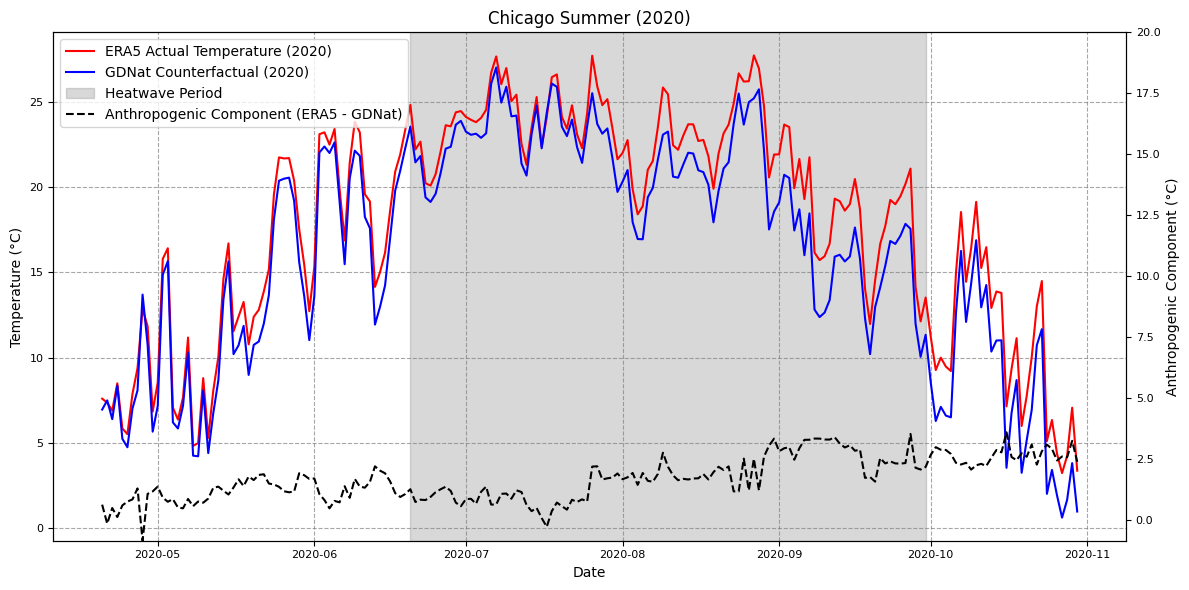

In [8]:
plot_heatwave_comparison(
    location=(41.88, 272.37),  # Chicago lat, ERA5 longitude
    heatwave_period=("2020-06-20", "2020-09-30"),  # Heatwave dates
    plot_range=("2020-04-20", "2020-10-30"), 
    title="Chicago Summer (2020)",
    heatwave = True
)


Plotting your GDNat and ERA5 plot...


/tmp/ipykernel_1963616/1210747063.py:27: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_data = xr.open_dataset(era5_file)


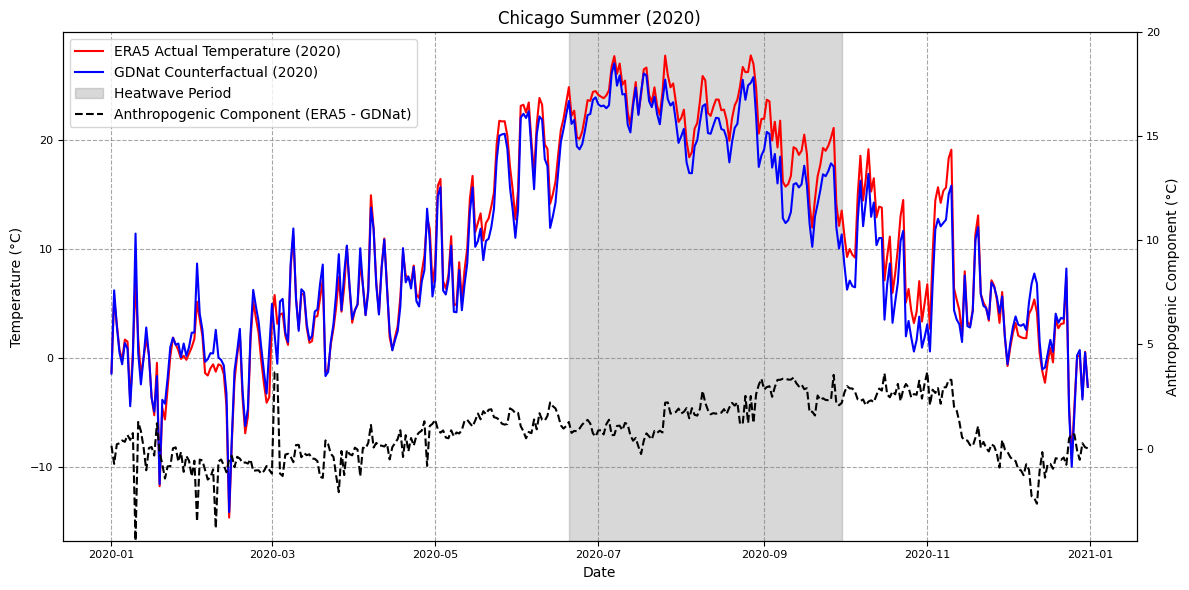

In [9]:
plot_heatwave_comparison(
    location=(41.88, 272.37),  # Chicago lat, ERA5 longitude
    heatwave_period=("2020-06-20", "2020-09-30"),  # Heatwave dates
    plot_range=("2020-01-01", "2020-12-31"), 
    title="Chicago Summer (2020)",
    heatwave = True
)

Plotting your GDNat and ERA5 plot...


/tmp/ipykernel_1963616/1210747063.py:27: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  era5_data = xr.open_dataset(era5_file)


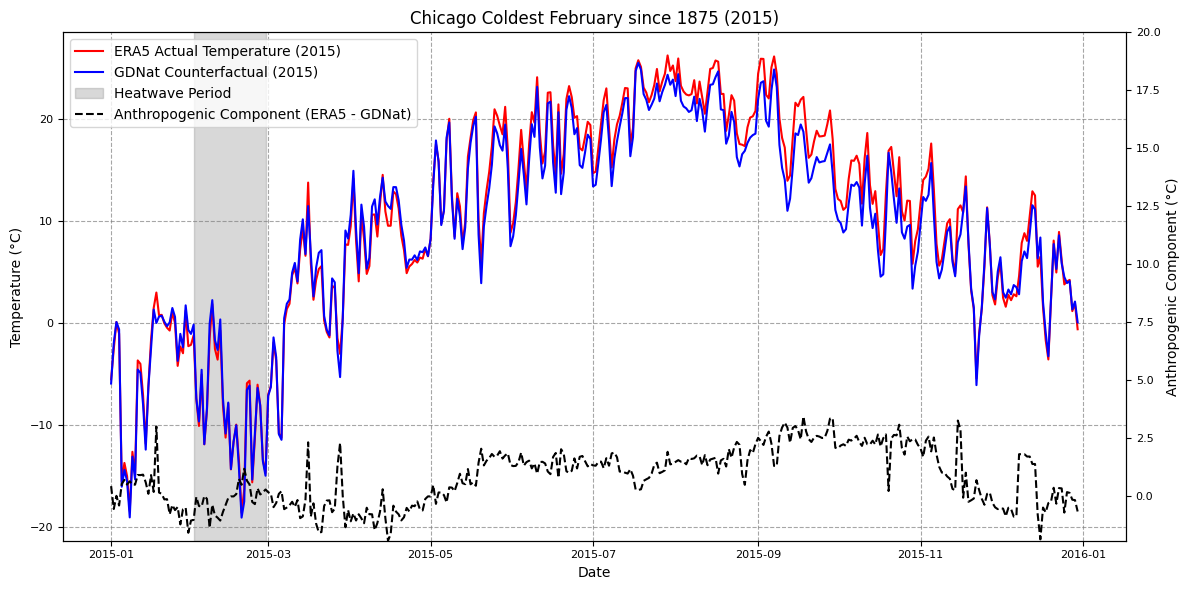

In [16]:


plot_heatwave_comparison(
    location=(41.88, 272.37),  # Chicago lat, ERA5 longitude
    heatwave_period=("2015-02-01", "2015-02-28"),  # Heatwave dates
    plot_range=("2015-01-01", "2015-12-30"), 
    title="Chicago Coldest February since 1875 (2015)",
    heatwave = True
)

In [ ]:


plot_heatwave_comparison(
    location=(41.88, 272.37),  # Chicago lat, ERA5 longitude
    heatwave_period=("2015-02-01", "2015-02-28"),  # Heatwave dates
    plot_range=("2015-01-01", "2015-12-30"), 
    title="Chicago Coldest February since 1875 (2015)",
    heatwave = True
)